# Predicting Nutrient Gaps: Amini Soil LightGBM (Extensive Feature Engineering with no Target Scaling, But Serious Model Optimization)¶¶

A.K.A Nail On The Coffin ( I am just kidding)😂😂

## ⚙️ Environment Setup & Package Imports

Before running the notebook, ensure all required libraries are installed in your environment.

### 📦 Install Additional Dependencies

This notebook uses the `bayesian-optimization` package for hyperparameter tuning. Install it using:

```python
!pip install bayesian-optimization --quiet
```

---

### 📚 Import Required Packages

This section imports all necessary libraries for:

* **Data handling**: `pandas`, `numpy`
* **Visualization**: `matplotlib`, `seaborn`
* **Modeling**: `LightGBM`, `sklearn`
* **Evaluation**: `mean_squared_error`, `KFold`
* **Utilities**: `os`, `statistics`, `warnings`


In [1]:
# Make sure all the libraries are installed in your env
!pip install bayesian-optimization --quiet

In [2]:
# IMPORT ALL PACKAGES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import os
import statistics
import warnings

# Suppress Warnings
warnings.filterwarnings('ignore')

In [3]:
# This is to view all columns

pd.set_option("display.max_columns", None)

## 📥 Load Soil Prediction Challenge Data

The function below loads all the required datasets for the **Amini Soil Prediction Challenge** from a specified directory. It reads in the training, test, and gap-filled datasets, along with satellite (LANDSAT8) data and the sample submission file.

### 🔧 Function: `load_soil_prediction_data`

* **Parameter:**

  * `base_path` *(str)*: Path to the dataset directory (default: Kaggle input folder path).
* **Returns:**

  * A dictionary containing the following DataFrames:

    * `train`: Training features and targets
    * `test`: Test features
    * `train_gap`: Gap-filled training set
    * `test_gap`: Gap-filled test set
    * `sample_submission`: Submission template
    * `landsat8_data`: Remote sensing data (LANDSAT 8)

```python
def load_soil_prediction_data(base_path='/kaggle/input/amini-soil-prediction-challenge-dataset'):
    """
    Loads all required datasets for the Amini Soil Prediction Challenge.

    Parameters:
    - base_path (str): Path to the dataset directory.

    Returns:
    - dict: A dictionary containing all loaded DataFrames.
    """
    train_df = pd.read_csv(f'{base_path}/Train.csv')
    test_df = pd.read_csv(f'{base_path}/Test.csv')
    train_gap_df = pd.read_csv(f'{base_path}/Gap_Train.csv')
    test_gap_df = pd.read_csv(f'{base_path}/Gap_Test.csv')
    sample_submission = pd.read_csv(f'{base_path}/SampleSubmission.csv')
    landsat8_data = pd.read_csv(f'{base_path}/LANDSAT8_data_updated.csv')
    
    return {
        "train": train_df,
        "test": test_df,
        "train_gap": train_gap_df,
        "test_gap": test_gap_df,
        "sample_submission": sample_submission,
        "landsat8_data": landsat8_data
    }
```

---


In [4]:
def load_soil_prediction_data(base_path='/kaggle/input/amini-soil-prediction-challenge-dataset'):
    """
    Loads all required datasets for the Amini Soil Prediction Challenge.

    Parameters:
    - base_path (str): Path to the dataset directory.

    Returns:
    - dict: A dictionary containing all loaded DataFrames.
    """
    train_df = pd.read_csv(f'{base_path}/Train.csv')
    test_df = pd.read_csv(f'{base_path}/Test.csv')
    train_gap_df = pd.read_csv(f'{base_path}/Gap_Train.csv')
    test_gap_df = pd.read_csv(f'{base_path}/Gap_Test.csv')
    sample_submission = pd.read_csv(f'{base_path}/SampleSubmission.csv')
    landsat8_data = pd.read_csv(f'{base_path}/LANDSAT8_data_updated.csv')
    
    return {
        "train": train_df,
        "test": test_df,
        "train_gap": train_gap_df,
        "test_gap": test_gap_df,
        "sample_submission": sample_submission,
        "landsat8_data": landsat8_data
    }


In [5]:
data = load_soil_prediction_data()
train_df = data["train"]
test_df = data["test"]
train_gap_df = data['train_gap']
test_gap_df = data['test_gap']
landsat8_data = data['landsat8_data']

## As usual let's skip exploration since they are in the previous notebooks😪

In [6]:
test_gap_df = pd.merge(test_gap_df, test_df[['PID', 'BulkDensity']], on='PID', how='left')

In [7]:
test_gap_df.head()

,Nutrient,Required,PID,BulkDensity
0,N,100.0,ID_NGS9Bx,1.2
1,P,40.0,ID_NGS9Bx,1.2
2,K,52.0,ID_NGS9Bx,1.2
3,Ca,12.0,ID_NGS9Bx,1.2
4,Mg,8.0,ID_NGS9Bx,1.2


In [8]:
target_columns = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']

In [9]:
# Drop target features to only get the train features for modelling.

train_fe = train_df.drop(columns=target_columns)

## 📐 Add Site-Level Statistical Features

This function enhances the dataset by computing **site-level summary statistics** (min, max, mean, median) for numeric columns and merging them back into the original DataFrame. This technique helps capture broader spatial patterns tied to each site.

### 🔧 Function: `add_site_level_statistics`

* **Parameters:**

  * `df` *(pd.DataFrame)*: The input DataFrame to enrich.
  * `group_col` *(str)*: The column used to group data (default: `'site'`).
  * `exclude_cols` *(list or None)*: List of columns to exclude from aggregation (defaults to `['PID', 'lon', 'lat', 'site']`).

* **Returns:**

  * A new DataFrame with original columns plus appended site-level statistical features.

In [10]:
def add_site_level_statistics(df, group_col='site', exclude_cols=None):
    """
    Computes site-level statistics and merges them back to the original dataframe.

    Parameters:
    - df (pd.DataFrame): Input DataFrame to aggregate.
    - group_col (str): Column name to group by (default is 'site').
    - exclude_cols (list): Columns to exclude from aggregation (default includes ['PID', 'lon', 'lat', 'site']).

    Returns:
    - pd.DataFrame: DataFrame with site-level statistics merged.
    """
    if exclude_cols is None:
        exclude_cols = ['PID', 'lon', 'lat', group_col]

    # Select numeric columns for aggregation
    agg_cols = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]

    # Compute group-level statistics
    site_stats = df.groupby(group_col)[agg_cols].agg(['min', 'max', 'mean', 'median'])

    # Flatten column names
    site_stats.columns = ['_'.join(col).strip() for col in site_stats.columns.values]

    # Reset index to prepare for merging
    site_stats.reset_index(inplace=True)

    # Merge statistics back into the original dataframe
    df_merged = df.merge(site_stats, on=group_col, how='left')

    return df_merged

In [11]:
train_fe = add_site_level_statistics(train_fe)
test_df = add_site_level_statistics(test_df)

In [12]:
train_fe.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,6.40,7.75,7.185,7.195,132,176,156.875000,167.0,247,249,248.000000,248.0,912,1018,955.250000,950.0,108,110,108.375000,108.0,190,191,190.25,190.0,0.058747,0.707932,0.353755,0.373809,22.00,33.25,29.468750,30.50,21.424564,23.590298,22.401946,22.366915,11.00779,25.231001,18.853312,17.048150,0.00000,0.2390,0.103311,0.04815,0.03,0.094082,0.045196,0.03,44.240669,46.608509,45.435076,45.488026,18.465033,19.427130,18.949129,18.940107,864.000427,2006.000488,1320.500130,1405.500061,1645.000732,3182.000732,2351.375214,2576.499878,464.000092,855.000244,599.500076,612.500031,1306.000122,2363.000732,1826.625031,1972.999939,1081,1097,1089.750000,1089.5,19.412239,24.103060,22.205113,22.318841,110.758514,243.023132,167.595243,135.761497,6.975,7.425,7.146875,7.050,0.447508,2.035072,1.009586,0.761513,31.50,43.00,37.843750,40.0,8.0,11.75,9.468750,9.125,7.962668,13.112203,10.245096,10.072555,0.016538,0.019393,0.017339,0.017097,0.000000,0.010284,0.004563,0.002838,1.38,1.47,1.447500,1.46
1,site_id_nGvnKc,ID_8jWzJ5,70.590479,46.078924,7.10,181,250,1080,113,191,0.707011,24.00,21.389599,14.023500,0.02350,0.030000,44.985626,19.730261,1637.000122,2839.000488,707.000061,2039.000488,1060,18.869566,109.835541,6.975,0.162065,40.00,8.00,8.439500,0.018321,0.001676,1.52,6.26,8.00,7.220,7.100,145,196,173.428571,174.0,249,252,250.285714,250.0,1008,1149,1086.857143,1109.0,110,113,111.428571,111.0,191,191,191.00,191.0,0.061296,0.707011,0.371490,0.362439,14.25,34.00,22.892857,23.75,17.022963,23.510744,19.944179,19.404194,14.02350,40.185001,21.082966,17.169001,0.00596,0.1850,0.082966,0.06240,0.03,0.110223,0.051956,0.03,42.409557,44.985626,43.842627,44.167717,18.270815,19.730261,19.220232,19.413284,966.999878,1642.000000,1372.999930,1382.999634,2046.999756,2910.000000,2557.714355,2531.999756,473.000061,772.999939,641.857143,631.999939,1309.000122,2107.999756,1842.285836,1961.000000,1022,1077,1051.857143,1049.0,18.869566,32.342995,25.213711,24.719807,109.835541,417.613312,234.243402,214.385269,6.625,7.025,6.782143,6.725,0.162065,2.499955,0.886719,0.708708,27.25,46.00,39.678571,43.5,8.0,10.75,9.321429,9.250,7.365927,12.241879,9.893438,8.666523,0.016913,0.020588,0.018852,0.018339,0.000372,0.009843,0.003725,0.003885,1.36,1.52,1.454286,1.48
2,site_id_nGvnKc,ID_UgzkN8,70.582553,46.048820,6.95,188,250,1109,111,191,0.362439,15.25,18.900057,16.062401,0.06240,0.030000,44.167717,19.413284,1639.999634,2903

In [13]:
test_df.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median
0,site_id_hgJpkz,ID_NGS9Bx,69.170794,44.522885,6.86,144,256,910,108,186,0.038132,44.75,1.581062,17.099701,0.0997,0.03,40.674942,18.333445,991.000061,2484.000488,486.000031,1413.000244,817,37.940418,467.619293,6.825,1.056416,25.50,15.25,8.732471,0.016981,0.005831,1.20,6.86,7.27,7.125000,7.185,139,144,141.500000,141.5,252,256,254.000000,254.0,910,1142,1021.500000,1017.0,108,110,109.000000,109.0,185,186,185.75,186.0,0.034111,0.071103,0.050398,0.048190,42.25,52.0,46.625,46.125,1.457660,5.482658,2.882902,2.295646,17.015301,21.152000,18.330776,17.577901,0.0153,0.152,0.080775,0.0779,0.03,0.030000,0.030000,0.030000,39.160236,40.674942,39.811288,39.704987,18.007334,18.333445,18.228101,18.285812,825.999939,991.000061,891.500000,874.500000,2374.000244,2484.000488,2428.000427,2427.000488,407.000000,486.000031,449.000015,451.500015,1238.000000,1413.000244,1322.250061,1319.000000,817,870,837.250000,831.0,37.940418,42.647343,40.499194,40.704508,404.839844,472.334045,440.700142,442.813339,6.725,6.825,6.768750,6.7625,0.962974,1.433321,1.108144,1.018141,22.00,26.00,24.375000,24.75,15.25,18.00,17.187500,17.75,8.732471,11.439353,10.057749,10.029587,0.016981,0.035683,0.026470,0.026608,0.000899,0.007186,0.004256,0.004469,1.20,1.25,1.2275,1.23
1,site_id_olmuI5,ID_YdVKXw,68.885265,44.741057,7.08,129,260,851,110,187,0.040187,53.00,5.700576,25.129000,0.1290,0.03,41.836205,18.762138,819.000000,2257.000000,412.000000,1199.000122,759,35.961353,542.590149,6.725,0.730379,18.75,14.00,10.565657,0.021030,0.005134,1.24,7.08,7.74,7.343333,7.210,129,131,129.666667,129.0,260,261,260.666667,261.0,841,851,846.333333,847.0,110,111,110.666667,111.0,187,187,187.00,187.0,0.040187,0.075281,0.053398,0.044726,53.00,60.0,56.000,55.000,4.160606,5.700576,4.889923,4.808586,25.129000,42.051498,34.082666,35.067501,0.0515,0.129,0.082667,0.0675,0.03,0.071170,0.043723,0.030000,41.836205,42.037308,41.922905,41.895203,18.762138,18.844263,18.810220,18.824259,819.000000,933.999695,860.999837,829.999817,2178.999512,2257.000000,2216.333089,2212.999756,412.000000,438.999969,425.333303,424.999939,1199.000122,1232.000000,1216.333333,1217.999878,748,759,751.666667,748.0,34.267311,35.961353,35.396673,35.961353,434.518616,542.590149,506.566305,542.590149,6.725,6.900,6.816667,6.8250,0.707549,1.069535,0.835821,0.730379,18.25,19.00,18.666667,18.75,11.75,14.00,12.833333,12.75,9.133697,12.951569,10.883641,10.565657,0.021030,0.024179,0.022297,0.021681,0.001225,0.005134,0.002761,0.001925,1.24,1.30,1.2600,1.24
2,site_id_PTZdJz,ID_MZAlfE,68.970210,44.675777,6.50,142,259,901,109,187,0.068795,49.00,6.823292,26.117001,0.1170,0.03,42.058319,18.344410,965.000000,2378.000244,444.999969,1324.000000,769

## 🛰️ Merge Aggregated LANDSAT8 Features

This function enriches both the training and test datasets by aggregating **LANDSAT8 satellite spectral features** at the `PID` level and merging the aggregated statistics into the main DataFrames.

### 🔧 Function: `merge_landsat8_aggregates`

* **Parameters:**

  * `train_df` *(pd.DataFrame)*: The original training dataset.
  * `test_df` *(pd.DataFrame)*: The original test dataset.
  * `landsat8_data` *(pd.DataFrame)*: Raw LANDSAT8 data containing spectral bands per `PID`.
  * `pid_col` *(str)*: Identifier column used for grouping (default: `'PID'`).

* **Returns:**

  * A tuple of two DataFrames: `(train_df_merged, test_df_merged)` — both augmented with LANDSAT8 statistical features.

* **Aggregated Features:**

  * Stats computed per `PID`: `mean`, `std`, `min`, and `max`
  * Columns aggregated include:
    `'QA_PIXEL'`, `'QA_RADSAT'`, `'SR_B1'` through `'SR_B7'`, and `'ST_B10'`


In [14]:
def merge_landsat8_aggregates(train_df, test_df, landsat8_data, pid_col='PID'):
    """
    Aggregates Landsat8 data by PID and merges the aggregated features with train and test DataFrames.

    Parameters:
    - train_df (pd.DataFrame): Training dataframe to merge with Landsat8 features.
    - test_df (pd.DataFrame): Test dataframe to merge with Landsat8 features.
    - landsat8_data (pd.DataFrame): Landsat8 raw data containing 'PID' and spectral bands.
    - pid_col (str): Column to group by (default is 'PID').

    Returns:
    - (pd.DataFrame, pd.DataFrame): Tuple of (train_df_merged, test_df_merged)
    """
    # Define numeric columns for aggregation
    landsat_numeric_cols = [
        'QA_PIXEL', 'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3',
        'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10'
    ]

    # Aggregate with multiple statistics
    landsat8_agg = landsat8_data.groupby(pid_col)[landsat_numeric_cols].agg(['mean', 'std', 'min', 'max']).reset_index()

    # Flatten multi-level column names
    landsat8_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in landsat8_agg.columns.values]

    # Merge with train and test data
    train_merged = train_df.merge(landsat8_agg, on=pid_col, how='left')
    test_merged = test_df.merge(landsat8_agg, on=pid_col, how='left')

    return train_merged, test_merged

In [15]:
train_fe, test_df = merge_landsat8_aggregates(train_fe, test_df, landsat8_data)

In [16]:
train_fe

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,6.40,7.75,7.185000,7.195,132,176,156.875000,167.0,247,249,248.000000,248.0,912,1018,955.250000,950.0,108,110,108.375000,108.0,190,191,190.250000,190.0,0.058747,0.707932,0.353755,0.373809,22.00,33.25,29.468750,30.500,21.424564,23.590298,22.401946,22.366915,11.00779,25.231001,18.853312,17.048150,0.00000,0.2390,0.103311,0.04815,0.03,0.094082,0.045196,0.03,44.240669,46.608509,45.435076,45.488026,18.465033,19.427130,18.949129,18.940107,864.000427,2006.000488,1320.500130,1405.500061,1645.000732,3182.000732,2351.375214,2576.499878,464.000092,855.000244,599.500076,612.500031,1306.000122,2363.000732,1826.625031,1972.999939,1081,1097,1089.750000,1089.5,19.412239,24.103060,22.205113,22.318841,110.758514,243.023132,167.595243,135.761497,6.975,7.425,7.146875,7.050,0.447508,2.035072,1.009586,0.761513,31.50,43.00,37.843750,40.000,8.00,11.75,9.468750,9.125,7.962668,13.112203,10.245096,10.072555,0.016538,0.019393,0.017339,0.017097,0.000000,0.010284,0.004563,0.002838,1.38,1.47,1.447500,1.460,23361.253731,6890.266312,21824.0,55052.0,0.0,0.0,0.0,0.0,0.106083,0.159315,0.021100,0.777405,0.128771,0.153452,0.038837,0.766268,0.184369,0.133760,0.085065,0.746110,0.229442,0.124249,0.095598,0.735770,0.356474,0.099793,0.179940,0.779550,0.374687,0.075534,0.161102,0.641610,0.237561,0.066450,0.101592,0.516650,1.076409,0.220386,-0.191942,1.265640
1,site_id_nGvnKc,ID_8jWzJ5,70.590479,46.078924,7.10,181,250,1080,113,191,0.707011,24.00,21.389599,14.023500,0.02350,0.030000,44.985626,19.730261,1637.000122,2839.000488,707.000061,2039.000488,1060,18.869566,109.835541,6.975,0.162065,40.00,8.00,8.439500,0.018321,0.001676,1.52,6.26,8.00,7.220000,7.100,145,196,173.428571,174.0,249,252,250.285714,250.0,1008,1149,1086.857143,1109.0,110,113,111.428571,111.0,191,191,191.000000,191.0,0.061296,0.707011,0.371490,0.362439,14.25,34.00,22.892857,23.750,17.022963,23.510744,19.944179,19.404194,14.02350,40.185001,21.082966,17.169001,0.00596,0.1850,0.082966,0.06240,0.03,0.11

In [17]:
train_fe.isnull().sum().sort_values()

site           0
mb3_min        0
mb3_max        0
mb3_mean       0
mb3_median     0
              ..
ST_B10_max     3
BulkDensity    4
ecec20         5
hp20           5
xhp20          5
Length: 189, dtype: int64

In [18]:
train_fe.describe()

,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
count,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7739.000000,7739.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7739.000000,7740.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.0,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7

In [19]:
test_df.describe()

,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
count,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.00000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.0,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,24

## 🎯 Create Target-Specific DataFrames

This utility function constructs a dictionary of DataFrames, each containing the same set of features (`train_fe`) but paired with a **single target column**. This structure is useful for training **individual models per target variable** in multi-target regression problems.

### 🔧 Function: `make_target_dfs`

* **Parameters:**

  * `train_fe` *(pd.DataFrame)*: DataFrame containing only engineered features.
  * `train_df` *(pd.DataFrame)*: Original training DataFrame containing both features and target columns.
  * `target_columns` *(list)*: List of target column names (e.g., `['N', 'P', 'K', ...]`).

* **Returns:**

  * `dict`: A dictionary where each key is a target name, and each value is a DataFrame with the full features plus that specific target.


In [20]:
def make_target_dfs(train_fe, train_df, target_columns):
    """
    Creates a dictionary of DataFrames with train_fe plus one target column.

    Args:
        train_fe (pd.DataFrame): DataFrame containing only feature columns.
        train_df (pd.DataFrame): Original DataFrame containing both features and targets.
        target_columns (list): List of target column names to add one at a time.

    Returns:
        dict: Dictionary mapping each target name to a DataFrame with features + that target.
    """
    target_dfs = {}
    for target in target_columns:
        df = train_fe.copy()
        df[target] = train_df[target]
        target_dfs[target] = df
    return target_dfs

In [21]:
target_dfs = make_target_dfs(train_fe, train_df, target_columns)

# Example: Access the DataFrame for 'K'
K_df = target_dfs['K']
N_df = target_dfs['N']
Ca_df = target_dfs['Ca']
P_df = target_dfs['P']
Mg_df = target_dfs['Mg']
Fe_df = target_dfs['Fe']
Mn_df = target_dfs['Mn']
Zn_df = target_dfs['Zn']
Cu_df = target_dfs['Cu']
B_df = target_dfs['B']
S_df = target_dfs['S']

In [22]:
K_df.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max,K
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,6.40,7.75,7.185,7.195,132,176,156.875000,167.0,247,249,248.000000,248.0,912,1018,955.250000,950.0,108,110,108.375000,108.0,190,191,190.25,190.0,0.058747,0.707932,0.353755,0.373809,22.00,33.25,29.468750,30.50,21.424564,23.590298,22.401946,22.366915,11.00779,25.231001,18.853312,17.048150,0.00000,0.2390,0.103311,0.04815,0.03,0.094082,0.045196,0.03,44.240669,46.608509,45.435076,45.488026,18.465033,19.427130,18.949129,18.940107,864.000427,2006.000488,1320.500130,1405.500061,1645.000732,3182.000732,2351.375214,2576.499878,464.000092,855.000244,599.500076,612.500031,1306.000122,2363.000732,1826.625031,1972.999939,1081,1097,1089.750000,1089.5,19.412239,24.103060,22.205113,22.318841,110.758514,243.023132,167.595243,135.761497,6.975,7.425,7.146875,7.050,0.447508,2.035072,1.009586,0.761513,31.50,43.00,37.843750,40.0,8.0,11.75,9.468750,9.125,7.962668,13.112203,10.245096,10.072555,0.016538,0.019393,0.017339,0.017097,0.000000,0.010284,0.004563,0.002838,1.38,1.47,1.447500,1.46,23361.253731,6890.266312,21824.0,55052.0,0.0,0.0,0.0,0.0,0.106083,0.159315,0.021100,0.777405,0.128771,0.153452,0.038837,0.766268,0.184369,0.133760,0.085065,0.746110,0.229442,0.124249,0.095598,0.735770,0.356474,0.099793,0.179940,0.779550,0.374687,0.075534,0.161102,0.641610,0.237561,0.066450,0.101592,0.516650,1.076409,0.220386,-0.191942,1.265640,147
1,site_id_nGvnKc,ID_8jWzJ5,70.590479,46.078924,7.10,181,250,1080,113,191,0.707011,24.00,21.389599,14.023500,0.02350,0.030000,44.985626,19.730261,1637.000122,2839.000488,707.000061,2039.000488,1060,18.869566,109.835541,6.975,0.162065,40.00,8.00,8.439500,0.018321,0.001676,1.52,6.26,8.00,7.220,7.100,145,196,173.428571,174.0,249,252,250.285714,250.0,1008,1149,1086.857143,1109.0,110,113,111.428571,111.0,191,191,191.00,191.0,0.061296,0.707011,0.371490,0.362439,14.25,34.00,22.892857,23.75,17.022963,23.510744,19.944179,19.404194,14.02350,40.185001,21.082966,17.169001,0.00596,0.1850,0.082966,0.06240,0.03,0.110223,0.051956,

## 🧪 Prepare Final Feature and Target Sets (Without Log Transform)

In this section, we construct the **feature matrices (`X_`)** and **target vectors (`y_`)** for each of the 11 soil nutrients. Unlike earlier versions, **no log transformation** is applied to the target variables — predictions will be made in their original scale.

---

### 🔹 **Feature Extraction**

For each nutrient:

* Drop `PID`, the target nutrient column (e.g., `'Ca'` for calcium), and `wp` (water potential).
* These excluded columns are either identifiers or the actual targets, which should not be used as model inputs.

```python
X_ca = Ca_df.drop(columns=['PID', 'Ca', 'wp'])
X_k  = K_df.drop(columns=['PID', 'K', 'wp'])
X_p  = P_df.drop(columns=['PID', 'P', 'wp'])
X_s  = S_df.drop(columns=['PID', 'S', 'wp'])
X_fe = Fe_df.drop(columns=['PID', 'Fe', 'wp'])
X_mg = Mg_df.drop(columns=['PID', 'Mg', 'wp'])
X_mn = Mn_df.drop(columns=['PID', 'Mn', 'wp'])
X_b  = B_df.drop(columns=['PID', 'B', 'wp'])
X_zn = Zn_df.drop(columns=['PID', 'Zn', 'wp'])
X_n  = N_df.drop(columns=['PID', 'N', 'wp'])
X_cu = Cu_df.drop(columns=['PID', 'Cu', 'wp'])
```

---

### 🎯 **Target Assignment**

Targets are now used **as-is**, without any transformation:

```python
y_ca = Ca_df['Ca']
y_k  = K_df['K']
y_p  = P_df['P']
y_s  = S_df['S']
y_fe = Fe_df['Fe']
y_mg = Mg_df['Mg']
y_mn = Mn_df['Mn']
y_b  = B_df['B']
y_zn = Zn_df['Zn']
y_n  = N_df['N']
y_cu = Cu_df['Cu']
```

---

### 🧪 **Prepare Test Set**

The test feature matrix is constructed similarly by removing non-feature columns:

```python
X_test = test_df.drop(columns=['PID', 'wp'])
```

---

✅ This structure is now ready for training LightGBM models and generating predictions directly in the original unit scale of each nutrient.

---


In [23]:
X_ca = Ca_df.drop(columns=['PID', 'Ca', 'wp'])
X_k = K_df.drop(columns=['PID', 'K', 'wp'])
X_p = P_df.drop(columns=['PID', 'P', 'wp'])
X_s = S_df.drop(columns=['PID', 'S', 'wp'])
X_fe = Fe_df.drop(columns=['PID', 'Fe', 'wp'])
X_mg = Mg_df.drop(columns=['PID', 'Mg', 'wp'])
X_mn = Mn_df.drop(columns=['PID', 'Mn', 'wp'])
X_b = B_df.drop(columns=['PID', 'B', 'wp'])
X_zn = Zn_df.drop(columns=['PID', 'Zn', 'wp'])
X_n = N_df.drop(columns=['PID', 'N', 'wp'])
X_cu = Cu_df.drop(columns=['PID', 'Cu', 'wp'])

y_ca = (Ca_df['Ca'])
y_k = (K_df['K'])
y_p = (P_df['P'])
y_s = (S_df['S'])
y_fe = (Fe_df['Fe'])
y_mg = (Mg_df['Mg'])
y_mn = (Mn_df['Mn'])
y_b = B_df['B']
y_zn = (Zn_df['Zn'])
y_n = (N_df['N'])
y_cu = (Cu_df['Cu'])

# For Test Set
X_test = test_df.drop(columns=['PID','wp'])

## 🔁 Convert Object Columns to Categorical

This utility function scans a DataFrame for columns with the `object` data type and converts them to `category` type. This is especially useful for memory optimization and modeling with algorithms (like LightGBM or CatBoost) that natively support categorical features.

### 🔧 Function: `change_object_to_cat`

* **Parameters:**

  * `df` *(pd.DataFrame)*: Input DataFrame with potential object-type columns.

* **Returns:**

  * `df` *(pd.DataFrame)*: Updated DataFrame with object columns converted to category type.
  * `list_str_obj_cols` *(list)*: List of column names that were converted.

In [24]:
def change_object_to_cat(df):
  # changes objects columns to category and returns dataframe and list

  df = df.copy()
  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  return df,list_str_obj_cols

In [25]:
X_n, cat_list = change_object_to_cat(X_n)
X_p, cat_list = change_object_to_cat(X_p)
X_k, cat_list = change_object_to_cat(X_k)
X_ca, cat_list = change_object_to_cat(X_ca)
X_mg, cat_list = change_object_to_cat(X_mg)
X_s, cat_list = change_object_to_cat(X_s)
X_fe, cat_list = change_object_to_cat(X_fe)
X_mn, cat_list = change_object_to_cat(X_mn)
X_zn, cat_list = change_object_to_cat(X_zn)
X_cu, cat_list = change_object_to_cat(X_cu)
X_b, cat_list = change_object_to_cat(X_b)

# For Test Set
X_test, cat_list = change_object_to_cat(X_test)

## 🌲📦 Stacked LightGBM Model Trainer with Bayesian Weighting

This section defines a framework to **train and stack multiple LightGBM model variants** using **K-Fold cross-validation**. The final ensemble combines predictions using **Bayesian Optimization** to learn the best set of weights for each fold.

---

### 🧰 Model Configuration: `LGBM_MODEL_CONFIGS`

A curated list of diverse LightGBM model configurations:

* **"precise"**: Deep and cautious learner with many rounds.
* **"feature\_selective"**: Uses feature fraction and regularization.
* **"robust"**: Conservative learner with shallower depth.
* **"deep\_forest"**: Deeper tree structure for complex patterns.
* **"highly\_regularized"**: Strong regularization to prevent overfitting.
* **"fast\_learner"**: Lightweight model for quick results.
* **"balanced"**: Balanced settings with moderate complexity.
* **"default"**: A simple fallback with default settings.

These diverse learners aim to capture different aspects of the data distribution.

---

### 🔁 Function: `train_stacked_lgbm_cv`

This function performs the following for **each fold** in K-Fold CV:

1. **Trains all configured LGBM models**.
2. **Collects predictions** from each model on the fold’s validation set.
3. **Optimizes ensemble weights** using Bayesian Optimization to minimize RMSE.
4. **Stores** the best model set and corresponding weights per fold.

#### **Parameters:**

* `X`, `y`: Feature matrix and target values.
* `model_configs`: List of model dictionaries (like `LGBM_MODEL_CONFIGS`).
* `n_folds` *(int)*: Number of folds in CV (default: 10).
* `categorical`: List of categorical column names or indices.
* `target_name` *(str)*: Name of the target for logging purposes.

#### **Returns:**

* `stacked_models`: List of tuples `(models, weights)` per fold.
* `cv_scores`: List of RMSE values per fold.
* `oof_preds`: Out-of-fold predictions using optimized ensemble.

---

### 🧠 Bayesian Weight Optimization

The ensemble weights are learned via **Bayesian Optimization**, maximizing the negative RMSE (i.e., minimizing RMSE) by tuning each model’s contribution to the final prediction:

```python
def objective_function(**weights):
    w = np.array([weights[f'w{i}'] for i in range(len(model_configs))])
    w = w / np.sum(w)
    pred = np.sum(fold_preds * w, axis=1)
    return -np.sqrt(mean_squared_error(y_val, pred))
```

* Each model is assigned a weight `w_i ∈ [0, 1]`, normalized to sum to 1.
* `BayesianOptimization` efficiently explores the weight space.

---

### ✅ Example Output

```text
Fold 1 RMSE: 0.42783
Fold 2 RMSE: 0.41521
...
Ca - Mean CV RMSE: 0.42156
```

This setup is ideal for combining multiple LightGBM learners while leveraging the strength of Bayesian ensemble weighting.

---


In [26]:
LGBM_MODEL_CONFIGS = [
    {"name": "precise", "params": {
                'n_estimators': 2000,
                'learning_rate': 0.01,
                'max_depth': 8,
                'num_leaves': 31,
                'colsample_bytree': 0.8,
                'subsample': 0.8,
                'reg_alpha': 0.1,
                'reg_lambda': 0.1,
                'min_child_weight': 10,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }},
    {"name": "feature_selective", "params": {
                'n_estimators': 1500,
                'learning_rate': 0.02,
                'max_depth': 6,
                'colsample_bytree': 0.6,
                'subsample': 0.9,
                'reg_alpha': 1.0,
                'reg_lambda': 0.1,
                'feature_fraction': 0.7,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }},
    {"name": "robust", "params": {
                'n_estimators': 1000,
                'learning_rate': 0.03,
                'max_depth': 5,
                'colsample_bytree': 0.9,
                'subsample': 0.7,
                'reg_alpha': 0.5,
                'reg_lambda': 1.0,
                'min_data_in_leaf': 20,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }},
    {"name": "deep_forest", "params": {
                'n_estimators': 3000,
                'learning_rate': 0.005,
                'max_depth': 12,
                'num_leaves': 64,
                'colsample_bytree': 0.75,
                'subsample': 0.75,
                'reg_alpha': 0.2,
                'reg_lambda': 0.2,
                'min_child_weight': 5,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 150
            }},
    {"name": "highly_regularized", "params": {
                'n_estimators': 1200,
                'learning_rate': 0.02,
                'max_depth': 4,
                'num_leaves': 16,
                'colsample_bytree': 0.7,
                'subsample': 0.8,
                'reg_alpha': 2.0,
                'reg_lambda': 2.0,
                'min_child_weight': 15,
                'min_data_in_leaf': 25,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }},
    {"name": "fast_learner", "params": {
                'n_estimators': 800,
                'learning_rate': 0.08,
                'max_depth': 6,
                'num_leaves': 32,
                'colsample_bytree': 0.85,
                'subsample': 0.85,
                'reg_alpha': 0.3,
                'reg_lambda': 0.3,
                'min_child_weight': 8,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 80
            }},
    {"name": "balanced", "params": {
                'n_estimators': 1800,
                'learning_rate': 0.015,
                'max_depth': 7,
                'num_leaves': 40,
                'colsample_bytree': 0.75,
                'subsample': 0.85,
                'reg_alpha': 0.4,
                'reg_lambda': 0.4,
                'min_child_weight': 12,
                'bagging_freq': 5,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 120
            }},
    {"name": "default", "params": {
        'n_estimators': 1000,
        'random_state': 42,
        'verbose': -1,
        'objective': 'rmse',
        'early_stopping_rounds': 120,
        'metric': 'rmse',
    }}
]

In [27]:
def train_stacked_lgbm_cv(X, y, model_configs, n_folds=10, categorical=None, target_name="target"):
    """
    Train a stacked ensemble of LGBMs using K-Fold CV and Bayesian optimization for weights.
    Returns: (stacked_models, cv_scores, oof_predictions)
    """
    from bayes_opt import BayesianOptimization
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    stacked_models = []
    optimal_weights_list = []
    oof_preds = np.zeros(len(y))
    oof_base_preds = np.zeros((len(y), len(model_configs)))
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        fold_models = []
        fold_preds = np.zeros((len(X_val), len(model_configs)))

        for i, config in enumerate(model_configs):
            model = lgb.LGBMRegressor(**config['params'])
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      categorical_feature=categorical,
                      callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(0)])

            fold_models.append(model)
            preds = model.predict(X_val, num_iteration=model.best_iteration_)
            fold_preds[:, i] = preds
            oof_base_preds[val_idx, i] = preds

        # --- Bayesian Optimization for best weights ---
        def objective_function(**weights):
            w = np.array([weights[f'w{i}'] for i in range(len(model_configs))])
            w = w / np.sum(w)
            pred = np.sum(fold_preds * w, axis=1)
            return -np.sqrt(mean_squared_error(y_val, pred))  # Negative RMSE

        pbounds = {f'w{i}': (0, 1) for i in range(len(model_configs))}
        optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, verbose=0, random_state=42)
        optimizer.maximize(init_points=10, n_iter=50)

        best_weights = np.array([optimizer.max['params'][f'w{i}'] for i in range(len(model_configs))])
        best_weights /= np.sum(best_weights)
        optimal_weights_list.append(best_weights)

        final_preds = np.sum(fold_preds * best_weights, axis=1)
        oof_preds[val_idx] = final_preds
        rmse = mean_squared_error(y_val, final_preds, squared=False)
        cv_scores.append(rmse)
        stacked_models.append((fold_models, best_weights))

        print(f"Fold {fold + 1} RMSE: {rmse:.5f}")

    mean_rmse = np.mean(cv_scores)
    print(f"{target_name} - Mean CV RMSE: {mean_rmse:.5f}")

    return stacked_models, cv_scores, oof_preds


## 🔁 Train Stacked LightGBM Models for All Nutrients

This loop performs **stacked model training** with **Bayesian-weighted ensembles** for each of the 11 soil nutrients.

---

### 🧷 Setup

* **`X_list`**: Feature sets for each nutrient.
* **`y_list`**: Corresponding targets.
* **`target_names`**: Display names used for logging and tracking.

---

### 🔄 Cross-Validated Stacked Training

For each nutrient:

1. The `train_stacked_lgbm_cv` function is called with:

   * The nutrient's features (`X`) and targets (`y`).
   * A diverse set of model configs (`LGBM_MODEL_CONFIGS`).
   * 10-fold cross-validation.
   * Bayesian optimization for optimal ensemble weights.

2. Results are stored in:

   * `models_dict`: Maps each target name to a list of fold-wise stacked models.
   * `cv_scores_dict`: Stores RMSE per fold for each target.

```python
from math import sqrt

# Initialize storage
rmse_list = []
models_dict = {}
cv_scores_dict = {}

# Loop over all nutrients
for X, y, name in zip(X_list, y_list, target_names):
    print(f"\n--- Training for {name} ---")
    stacked_models, cv_scores, oof_preds = train_stacked_lgbm_cv(
        X, y, LGBM_MODEL_CONFIGS, n_folds=10, categorical=cat_list, target_name=name
    )
    models_dict[name.lower()] = stacked_models
    cv_scores_dict[name.lower()] = cv_scores
    print(f"{name} CV RMSE: {np.mean(cv_scores):.5f}")
```

---

✅ After this loop:

* You’ll have **fold-trained stacked models** for each nutrient.
* Ready to use for ensemble predictions on test data.

---


In [28]:
# Define the features and targets
X_list = [X_n, X_p, X_k, X_ca, X_mg, X_s, X_fe, X_mn, X_zn, X_cu, X_b]
y_list = [y_n, y_p, y_k, y_ca, y_mg, y_s, y_fe, y_mn, y_zn, y_cu, y_b]
target_names = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']

from math import sqrt

# Initialize RMSE accumulator
rmse_list = []

# Run cross-validation for each target and store models + RMSE
models_dict = {}
cv_scores_dict = {}

for X, y, name in zip(X_list, y_list, target_names):
    print(f"\n--- Training for {name} ---")
    stacked_models, cv_scores, oof_preds = train_stacked_lgbm_cv(
        X, y, LGBM_MODEL_CONFIGS, n_folds=10, categorical=cat_list, target_name=name
    )
    models_dict[name.lower()] = stacked_models
    cv_scores_dict[name.lower()] = cv_scores
    print(f"{name} CV RMSE: {np.mean(cv_scores):.5f}")


--- Training for N ---
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[498]	valid_0's rmse: 488.688
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's rmse: 489.45
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	valid_0's rmse: 481.33
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	valid_0's rmse: 486.184
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 491.025
Fold 1 RMSE: 481.33033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1518]	valid_0's rmse: 473.096
Traini

I hate to admit this, but it takes so long! However it is worth it, So hang it there a bit😜👌

## 📊 Visualizing Top Feature Importances per Nutrient

To better understand the contribution of each feature to the predictions, we plot the **top 35 most important features** for one representative model from each nutrient’s stacked ensemble.

---

### 🧠 `plot_single_model_importance`

This function plots the **feature importances** (by gain) from a single LightGBM model:

### 🔍 Feature Importance Plots

We extract the **3rd fold’s 1st model** (`models_dict['target'][2][0][0]`) for each nutrient and visualize its feature contributions:


Each plot reveals the **most influential features** that the model relies on to predict a given nutrient, helping guide further **feature selection, engineering, or interpretation**.


In [29]:
def plot_single_model_importance(model, feature_names, top_n=20):
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'], color='green')
    plt.xlabel('Gain Importance')
    plt.title(f'Top {top_n} Feature Importances (Single Model)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

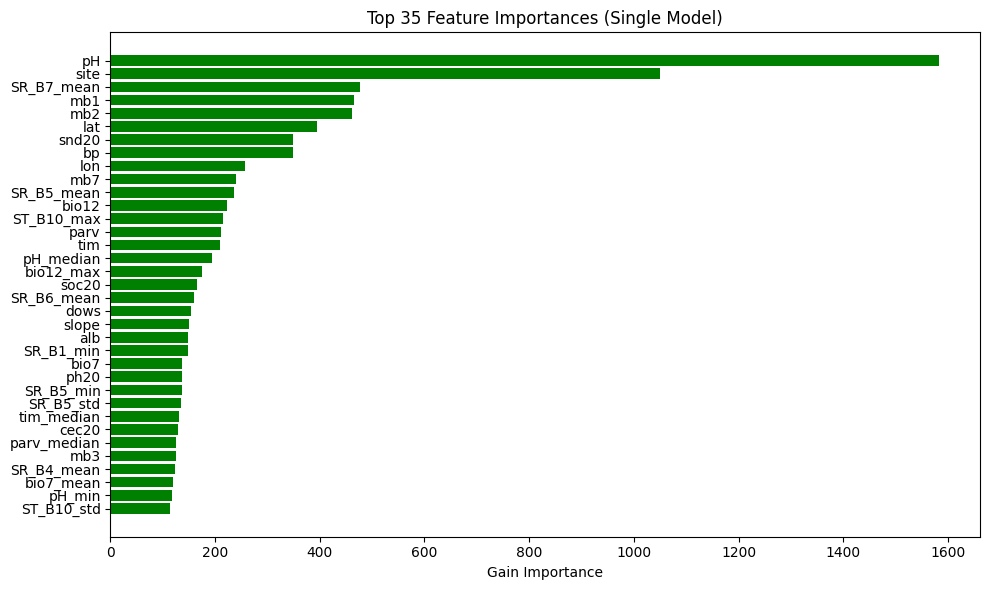

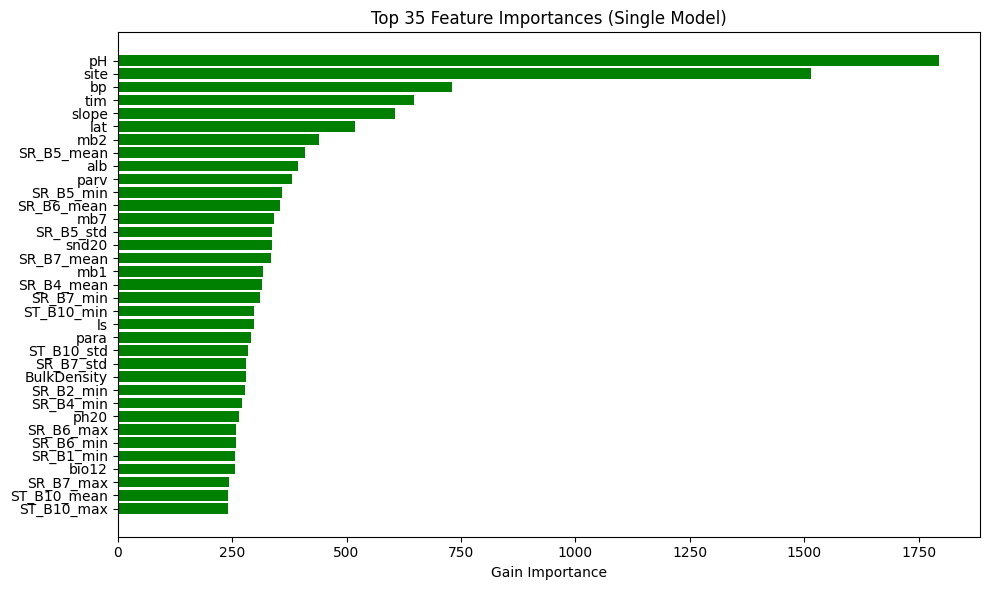

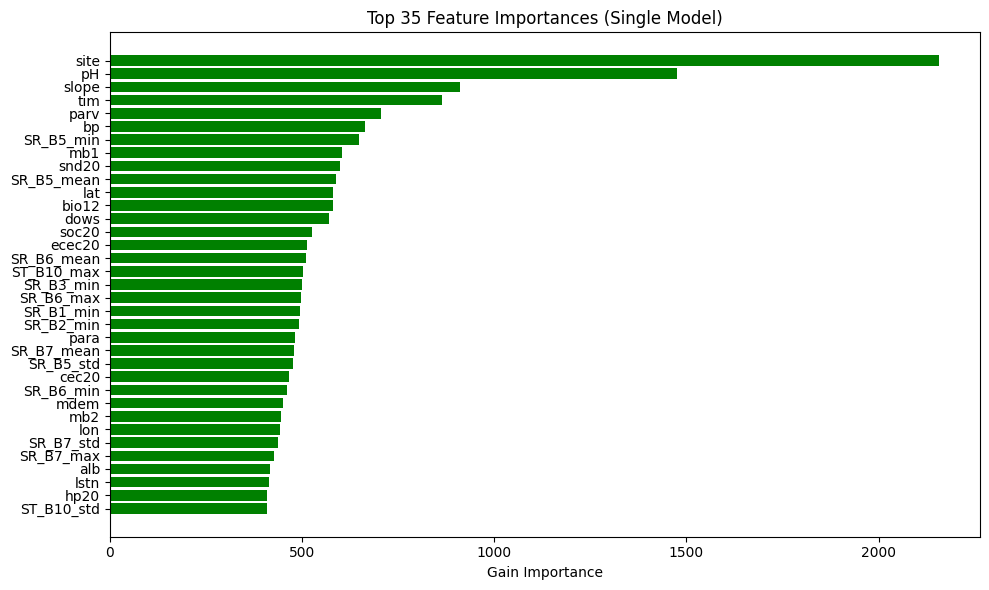

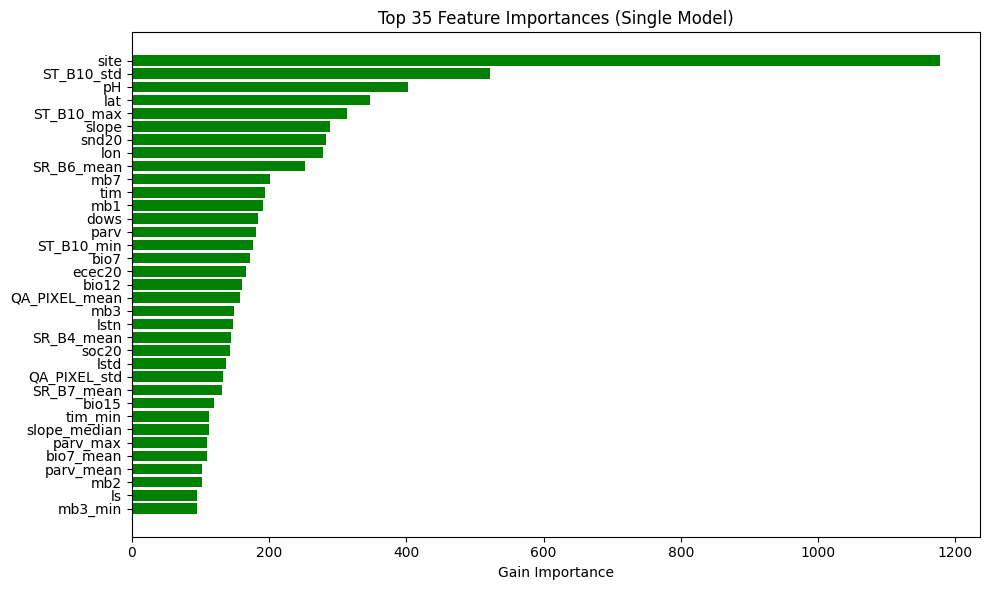

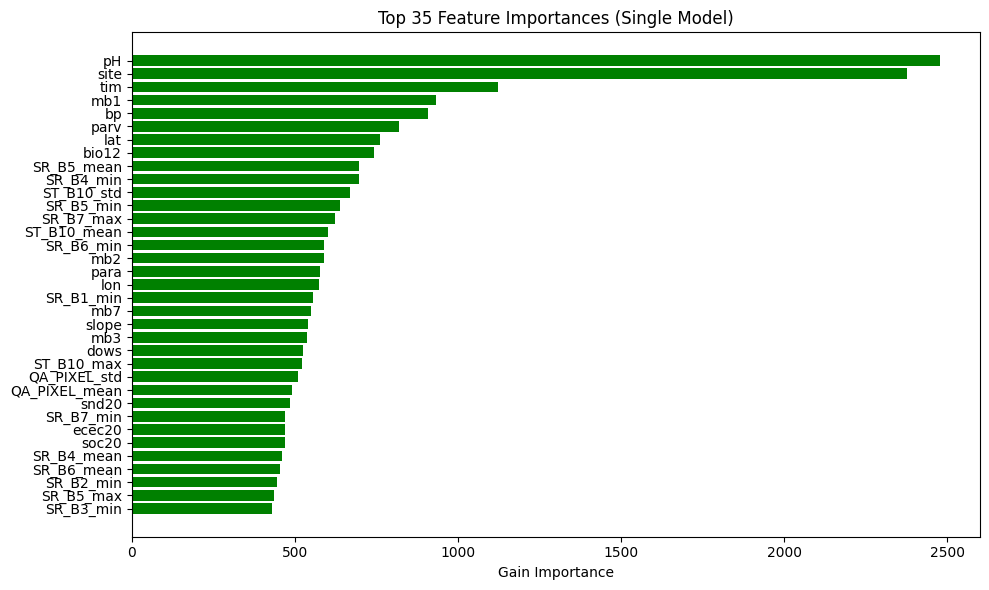

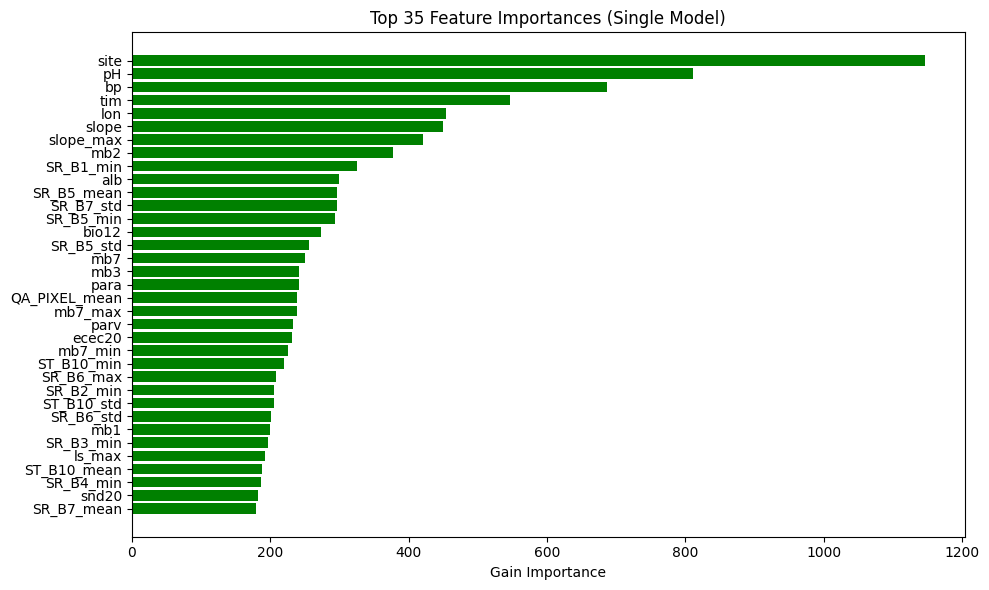

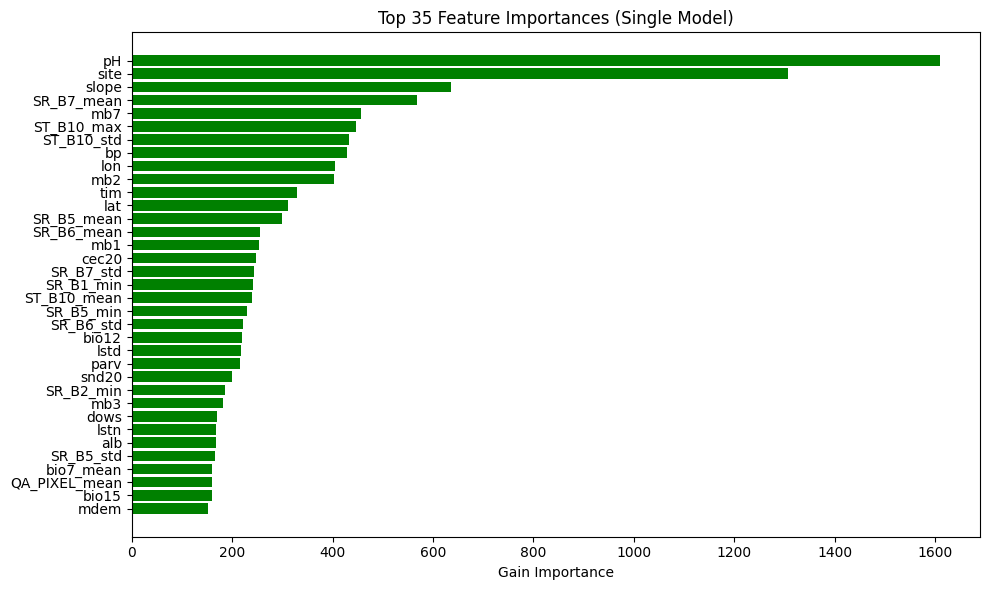

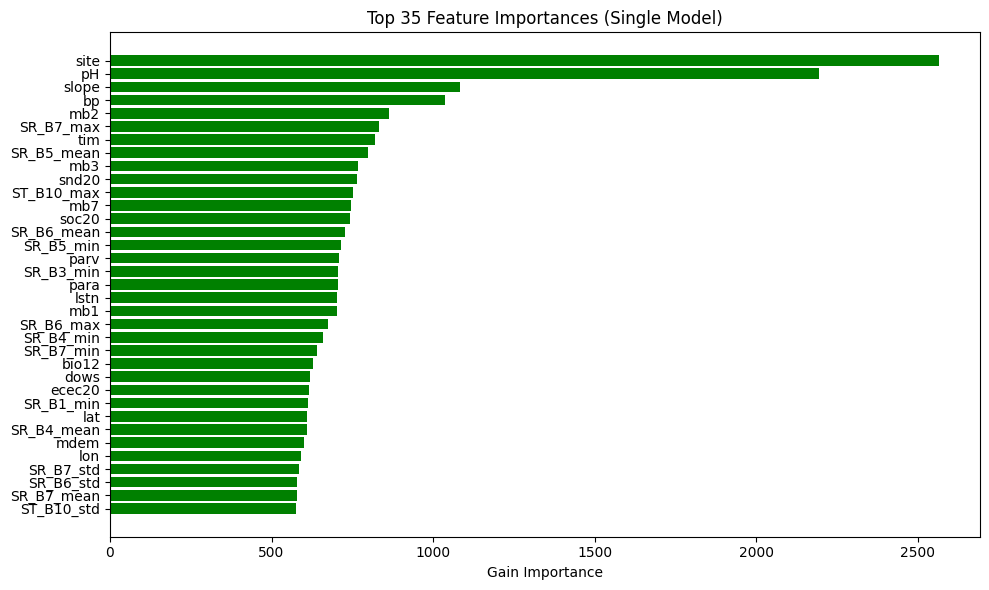

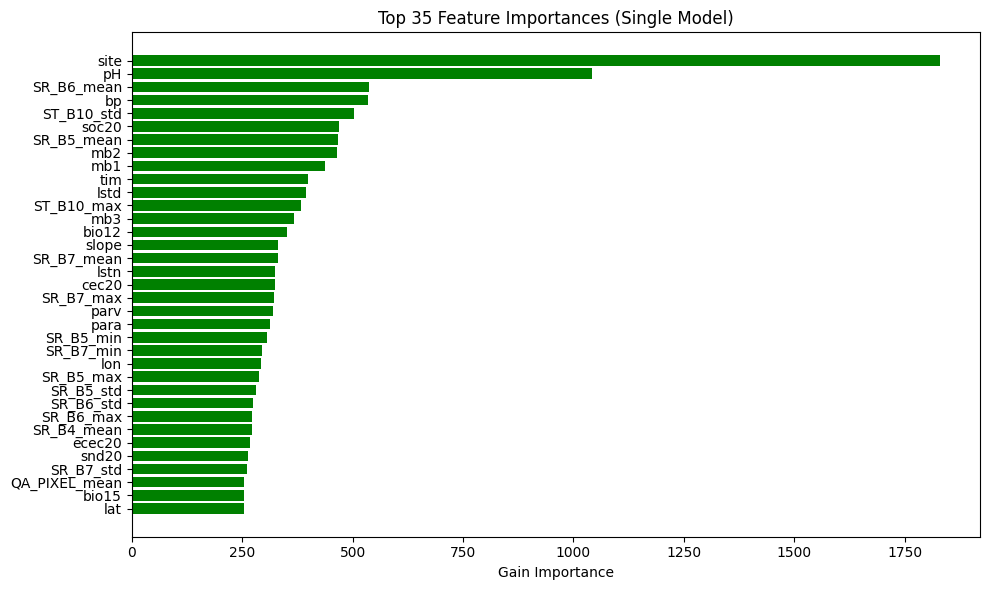

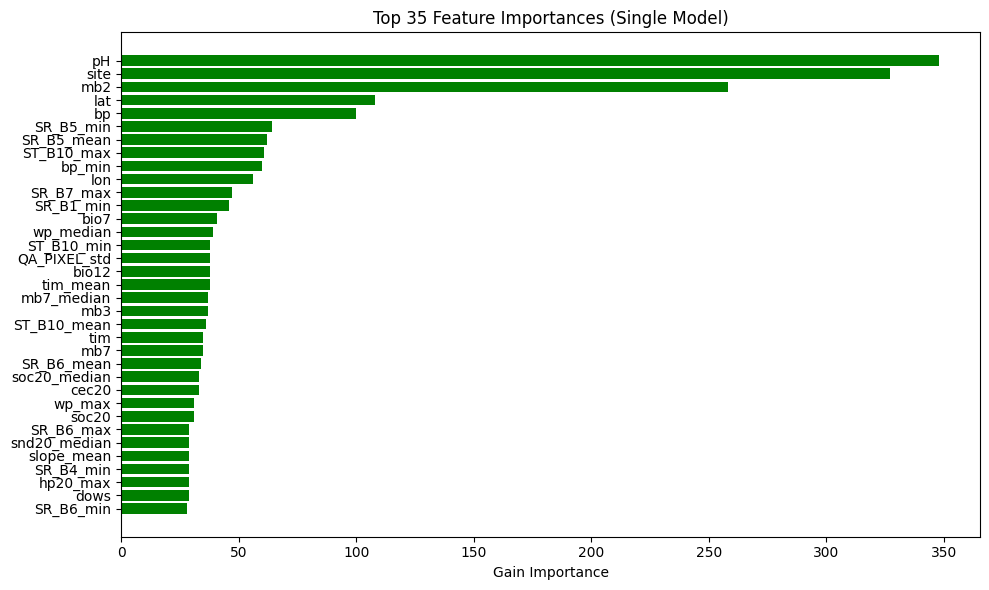

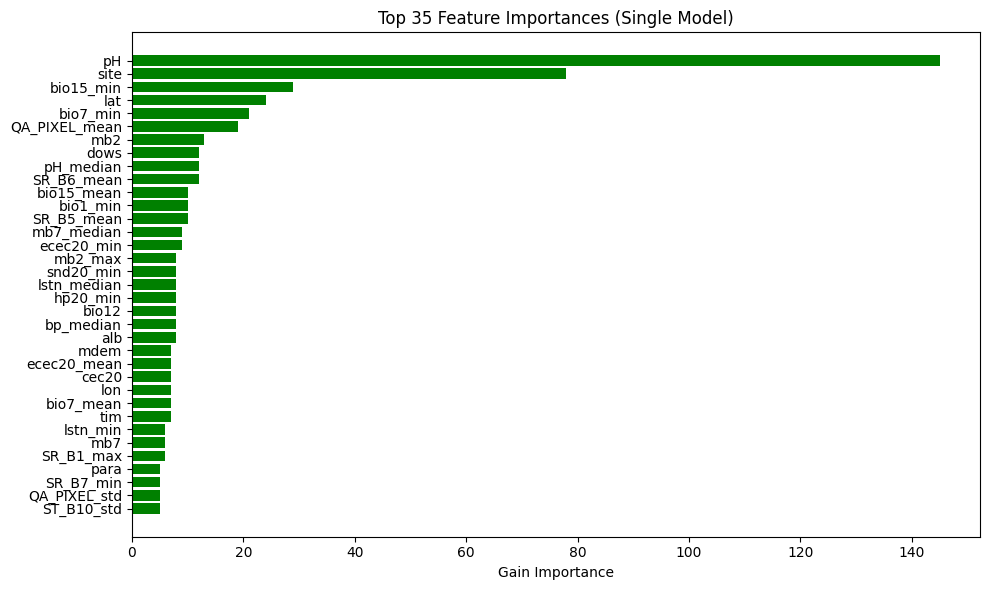

In [30]:
plot_single_model_importance(models_dict['ca'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['k'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['mn'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['cu'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['b'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['p'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['mg'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['fe'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['n'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['zn'][2][0][0], X.columns, top_n=35)
plot_single_model_importance(models_dict['s'][2][0][0], X.columns, top_n=35)

## 🧠 Extract Trained Models by Target

After cross-validation, the trained LightGBM models for each nutrient are stored in the `models_dict` dictionary. The following lines extract the list of trained models (one per fold) for each nutrient and assign them to individual variables for easier access and further analysis or prediction.

Each variable (e.g., `models_n`) holds a list of LightGBM models trained on that specific nutrient using K-Fold cross-validation.

In [31]:
models_n  = models_dict['n']
models_p  = models_dict['p']
models_k  = models_dict['k']
models_ca = models_dict['ca']
models_mg = models_dict['mg']
models_s  = models_dict['s']
models_fe = models_dict['fe']
models_mn = models_dict['mn']
models_zn = models_dict['zn']
models_cu = models_dict['cu']
models_b  = models_dict['b']

In [32]:
X_test.head()

,site,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
0,site_id_hgJpkz,69.170794,44.522885,6.86,144,256,910,108,186,0.038132,44.75,1.581062,17.099701,0.0997,0.03,40.674942,18.333445,991.000061,2484.000488,486.000031,1413.000244,817,37.940418,467.619293,6.825,1.056416,25.50,15.25,8.732471,0.005831,1.20,6.86,7.27,7.125000,7.185,139,144,141.500000,141.5,252,256,254.000000,254.0,910,1142,1021.500000,1017.0,108,110,109.000000,109.0,185,186,185.75,186.0,0.034111,0.071103,0.050398,0.048190,42.25,52.0,46.625,46.125,1.457660,5.482658,2.882902,2.295646,17.015301,21.152000,18.330776,17.577901,0.0153,0.152,0.080775,0.0779,0.03,0.030000,0.030000,0.030000,39.160236,40.674942,39.811288,39.704987,18.007334,18.333445,18.228101,18.285812,825.999939,991.000061,891.500000,874.500000,2374.000244,2484.000488,2428.000427,2427.000488,407.000000,486.000031,449.000015,451.500015,1238.000000,1413.000244,1322.250061,1319.000000,817,870,837.250000,831.0,37.940418,42.647343,40.499194,40.704508,404.839844,472.334045,440.700142,442.813339,6.725,6.825,6.768750,6.7625,0.962974,1.433321,1.108144,1.018141,22.00,26.00,24.375000,24.75,15.25,18.00,17.187500,17.75,8.732471,11.439353,10.057749,10.029587,0.016981,0.035683,0.026470,0.026608,0.000899,0.007186,0.004256,0.004469,1.20,1.25,1.2275,1.23,25359.955224,10159.910930,21824,55052,0.0,0.0,0,0,0.080165,0.128953,-0.083867,0.894473,0.096425,0.124520,0.004105,0.884848,0.138135,0.116921,0.039442,0.847668,0.154674,0.117727,0.034877,0.835705,0.297082,0.106241,0.168417,0.830480,0.263856,0.073856,0.091143,0.528998,0.190497,0.072419,0.050360,0.454005,1.077676,0.197278,0.505402,1.300812
1,site_id_olmuI5,68.885265,44.741057,7.08,129,260,851,110,187,0.040187,53.00,5.700576,25.129000,0.1290,0.03,41.836205,18.762138,819.000000,2257.000000,412.000000,1199.000122,759,35.961353,542.590149,6.725,0.730379,18.75,14.00,10.565657,0.005134,1.24,7.08,7.74,7.343333,7.210,129,131,129.666667,129.0,260,261,260.666667,261.0,841,851,846.333333,847.0,110,111,110.666667,111.0,187,187,187.00,187.0,0.040187,0.075281,0.053398,0.044726,53.00,60.0,56.000,55.000,4.160606,5.700576,4.889923,4.808586,25.129000,42.051498,34.082666,35.067501,0.0515,0.129,0.082667,0.0675,0.03,0.071170,0.043723,0.030000,41.836205,42.037308,41.922905,41.895203,18.762138,18.844263,18.810220,18.8242

## 📈 Generating Final Predictions with Stacked Ensemble

After training stacked LightGBM models for each nutrient, we generate final predictions on the **test set** using all folds’ base models and their **Bayesian-optimized ensemble weights**.

---

### 🧠 `get_mean_prediction`

This function takes a list of `(models, weights)` tuples (i.e., fold-wise ensembles) and:

1. **Predicts using each model** in the fold.
2. **Applies the optimized weights** to compute a weighted average per fold.
3. **Aggregates fold predictions** by taking the median across folds (for robustness).

In [33]:
def get_mean_prediction(stacked_models, X):
    """
    Generates predictions from stacked ensemble models.
    Each item in stacked_models is (base_models, weights).
    Final prediction is the average of all fold predictions.
    """
    fold_preds = []

    for base_models, weights in stacked_models:
        base_preds = np.array([model.predict(X) for model in base_models])
        weighted_pred = np.average(base_preds, axis=0, weights=weights)
        fold_preds.append(weighted_pred)

    # Average predictions across folds
    return np.median(fold_preds, axis=0)

### 🧪 Predicting Test Set Nutrient Values

For each of the 11 nutrients, predictions are made using the trained and stacked models:


These are the **final model predictions** to be used for submission.

In [34]:
# Get averaged predictions for each target
N_pred  = get_mean_prediction(models_n, X_test)
P_pred  = get_mean_prediction(models_p, X_test)
K_pred  = get_mean_prediction(models_k, X_test)
Ca_pred = get_mean_prediction(models_ca, X_test)
Mg_pred = get_mean_prediction(models_mg, X_test)
S_pred  = get_mean_prediction(models_s, X_test)
Fe_pred = get_mean_prediction(models_fe, X_test)
Mn_pred = get_mean_prediction(models_mn, X_test)
Zn_pred = get_mean_prediction(models_zn, X_test)
Cu_pred = get_mean_prediction(models_cu, X_test)
B_pred  = get_mean_prediction(models_b, X_test)

And from here onwards, everything follows exactly as in the previous notebook. 👌

In [35]:
submission = pd.DataFrame({'PID': test_df['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission.head()

,PID,N,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
0,ID_NGS9Bx,1662.530566,7.727359,158.923640,5192.586952,1607.922136,9.985808,113.958024,132.940973,2.753733,4.019756,0.222378
1,ID_YdVKXw,1282.544396,9.543154,215.144793,6577.231815,2005.124443,10.014763,108.875961,123.726041,1.651319,4.117272,0.224646
2,ID_MZAlfE,1584.748222,7.440375,187.242745,5197.211479,2078.374141,10.055452,114.709486,135.598414,2.364921,4.068637,0.183387
3,ID_GwCCMN,1681.251172,8.615367,227.898741,5253.404487,1687.300254,10.197505,128.656568,155.392170,1.882586,3.853658,0.223512
4,ID_K8sowf,1808.623042,8.199442,177.352415,4487.384107,1555.990081,9.985400,134.234786,140.386768,2.121901,3.928159,0.206642


In [36]:
# prompt: turn submission into a 3 column file that has the column PID, Nutrient, Value

submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')
submission_melted.head()

,PID,Nutrient,Available_Nutrients_in_ppm
19869,ID_002W8m,Zn,2.277108
15033,ID_002W8m,Fe,151.906054
2943,ID_002W8m,P,8.007696
24705,ID_002W8m,B,0.343115
525,ID_002W8m,N,2142.820287


In [37]:
# prompt: merge test_gap_df with submission_melted on PID and Nutrient
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')

In [38]:
nutrient_df

,Nutrient,Required,PID,BulkDensity,Available_Nutrients_in_ppm
0,N,100.00,ID_NGS9Bx,1.20,1662.530566
1,P,40.00,ID_NGS9Bx,1.20,7.727359
2,K,52.00,ID_NGS9Bx,1.20,158.923640
3,Ca,12.00,ID_NGS9Bx,1.20,5192.586952
4,Mg,8.00,ID_NGS9Bx,1.20,1607.922136
...,...,...,...,...,...
26593,Fe,0.80,ID_oMn2Yb,1.14,169.037548
26594,Mn,0.40,ID_oMn2Yb,1.14,173.634738
26595,Zn,0.40,ID_oMn2Yb,1.14,4.955318
26596,Cu,0.20,ID_oMn2Yb,1.14,1.975625


In [39]:
test_gap_df

,Nutrient,Required,PID,BulkDensity
0,N,100.00,ID_NGS9Bx,1.20
1,P,40.00,ID_NGS9Bx,1.20
2,K,52.00,ID_NGS9Bx,1.20
3,Ca,12.00,ID_NGS9Bx,1.20
4,Mg,8.00,ID_NGS9Bx,1.20
...,...,...,...,...
26593,Fe,0.80,ID_oMn2Yb,1.14
26594,Mn,0.40,ID_oMn2Yb,1.14
26595,Zn,0.40,ID_oMn2Yb,1.14
26596,Cu,0.20,ID_oMn2Yb,1.14


In [40]:
soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

In [41]:
nutrient_df.head()

,Nutrient,Required,PID,BulkDensity,Available_Nutrients_in_ppm,Available_Nutrients_in_kg_ha
0,N,100.0,ID_NGS9Bx,1.2,1662.530566,3990.073357
1,P,40.0,ID_NGS9Bx,1.2,7.727359,18.545663
2,K,52.0,ID_NGS9Bx,1.2,158.923640,381.416736
3,Ca,12.0,ID_NGS9Bx,1.2,5192.586952,12462.208686
4,Mg,8.0,ID_NGS9Bx,1.2,1607.922136,3859.013127


In [42]:
nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]
nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]
nutrient_df.head()

,ID,Gap
0,ID_NGS9Bx_N,-3890.073357
1,ID_NGS9Bx_P,21.454337
2,ID_NGS9Bx_K,-329.416736
3,ID_NGS9Bx_Ca,-12450.208686
4,ID_NGS9Bx_Mg,-3851.013127


In [43]:
nutrient_df.to_csv('lgbm_submission_no_log.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


Whew — that was quite a bit of work! 😮‍💨 Now, let’s move on to ensembling the predictions.